In [1]:
# Configurations related to Kafka connector 
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.0 pyspark-shell'



In [2]:
from pyspark.sql import *
from pyspark.sql.functions import json_tuple,from_json,explode,col
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.sql.types import StructType,FloatType, StructField, StringType,TimestampType
import json
import pandas as pd
import time

spark = SparkSession \
    .builder \
    .appName("SparkStreaming") \
    .getOrCreate()

In [3]:
spark.conf.set("spark.sql.shuffle.partitions", 10)

In [4]:
# Construct a streaming DataFrame that reads from topic1
socketDF = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9092") \
  .option("subscribe", "incoming_tweets") \
  .load()

In [5]:
schema = StructType(
    [
        StructField("created_at",TimestampType(), True),\
        StructField("text",StringType(), True),\
        StructField("id",StringType(), True),\
        StructField("sentimentScore",FloatType(), True),\
        StructField("sentiment",StringType(), True)
    ]
)

In [6]:
json = socketDF.selectExpr("CAST(value AS STRING) as data")

json = json.withColumn("data",from_json(json.data,schema))\
    
data = json.select(col('data.*'))

In [7]:
query=data.writeStream\
    .outputMode("append")\
    .format("memory")\
    .queryName("data")\
    .start()

In [8]:
avgSentiment = spark.sql("""
SELECT avg(sentimentScore), date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                              FROM data
                              GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes')
                              ORDER BY time 
""")

In [9]:
totalCounts = spark.sql("""
SELECT count(*) as count,count(distinct id) as idCount FROM data
""")

In [10]:
totalCounts.show()

+-----+-------+
|count|idCount|
+-----+-------+
|    0|      0|
+-----+-------+



In [11]:
sentimentCounts = spark.sql("""
SELECT count(*) as count,sentiment, date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                              FROM data
                              GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes'),sentiment
                              ORDER BY time desc
""")

In [12]:
from IPython.display import clear_output

starttime=time.time()
while True:
    sentimentCounts.show()
    avgSentiment.show()
    time.sleep(5.0- ((time.time() - starttime) % 5.0))
    clear_output()
    


+-----+---------+-------------------+
|count|sentiment|               time|
+-----+---------+-------------------+
|   53| negative|2019-02-16 22:53:00|
|    8|  neutral|2019-02-16 22:53:00|
|   19| positive|2019-02-16 22:53:00|
|   10| positive|2019-02-16 22:52:00|
|   30| negative|2019-02-16 22:52:00|
|    9|  neutral|2019-02-16 22:52:00|
|    1| negative|2019-02-16 16:24:00|
|    1| positive|2019-02-16 15:21:00|
|    1| positive|2019-02-15 08:06:00|
+-----+---------+-------------------+

+-------------------+-------------------+
|avg(sentimentScore)|               time|
+-------------------+-------------------+
|                2.0|2019-02-15 08:06:00|
|                5.0|2019-02-16 15:21:00|
|               -2.0|2019-02-16 16:24:00|
|-0.5510204081632653|2019-02-16 22:52:00|
|               -0.2|2019-02-16 22:53:00|
+-------------------+-------------------+



KeyboardInterrupt: 

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

22:59:16


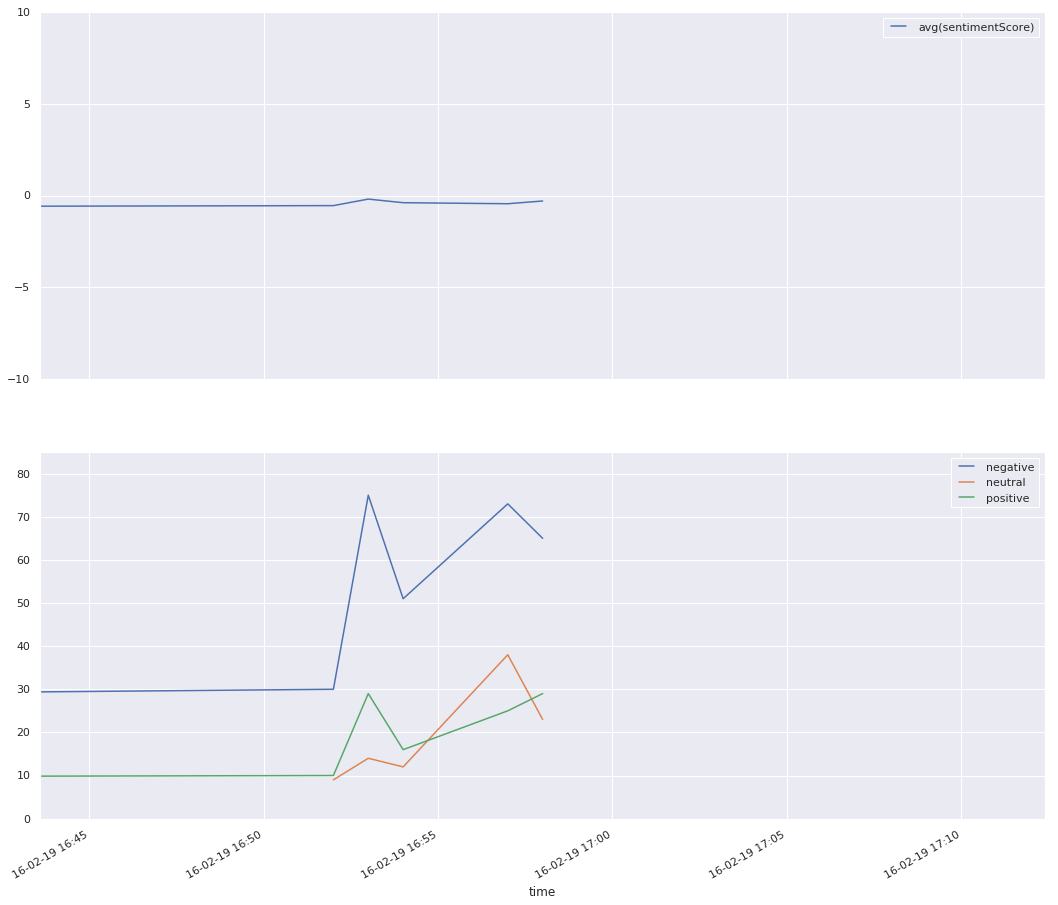

22:59:23


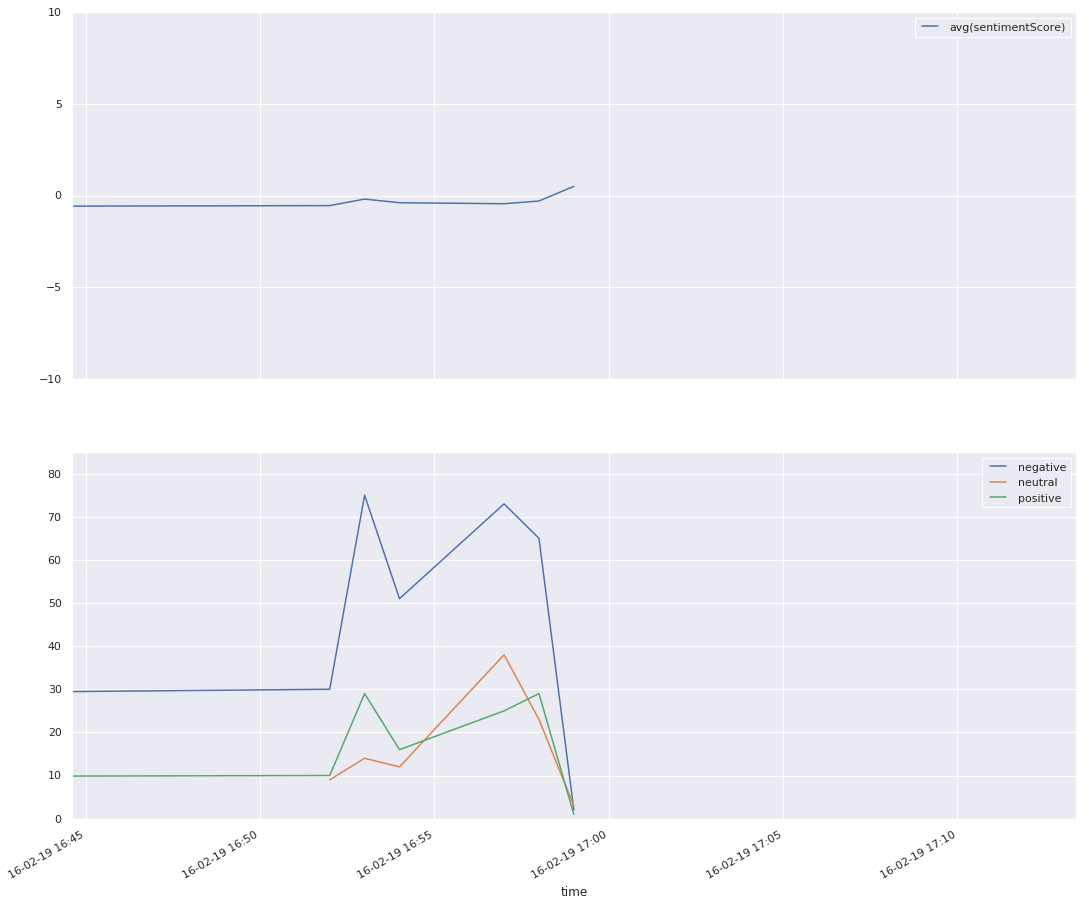

22:59:29


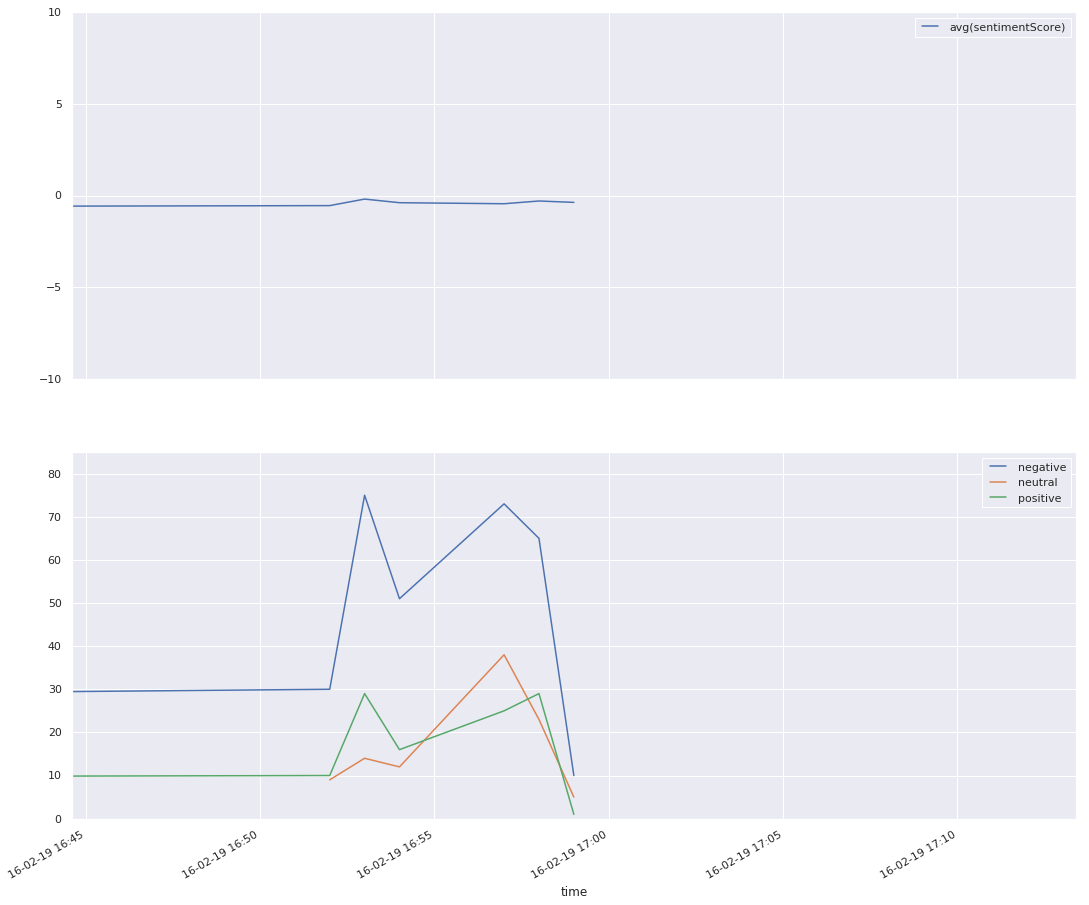

22:59:36


KeyboardInterrupt: 

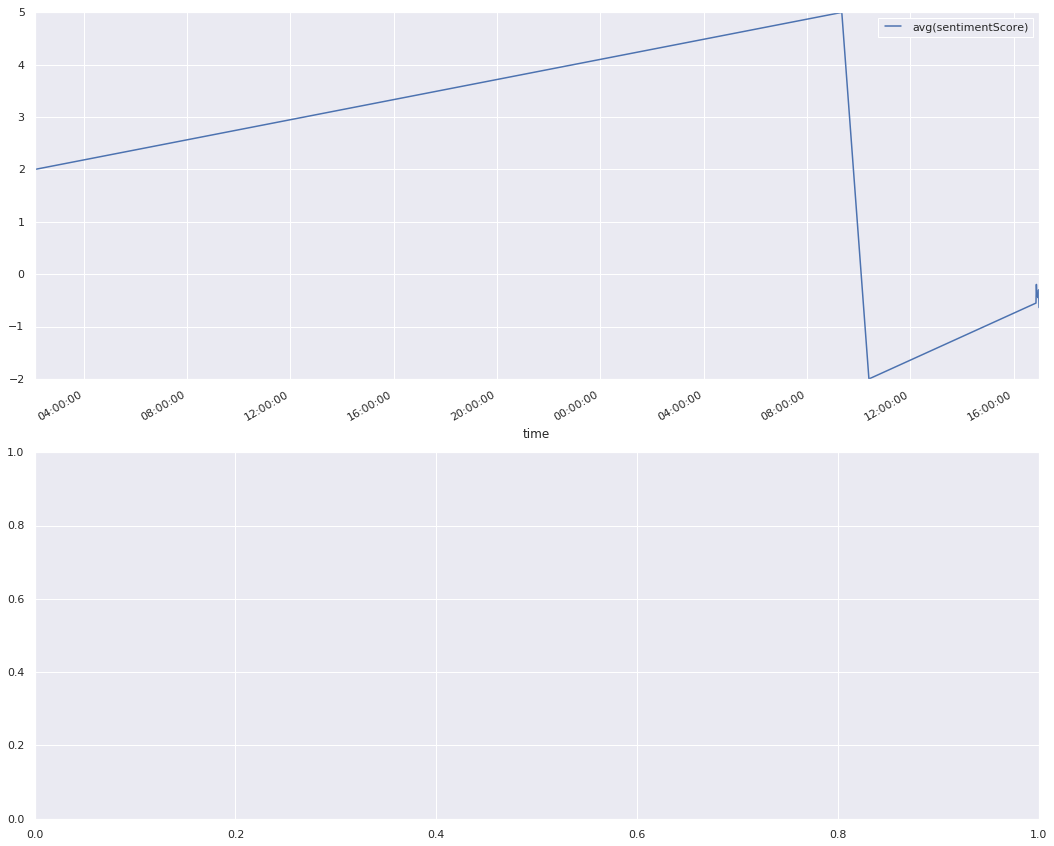

In [26]:

while True:
    print(datetime.datetime.fromtimestamp(time.time()).strftime('%H:%M:%S'))
    fig, ax = plt.subplots(2,1,figsize=(18, 16))
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')


    avgSentiment = spark.sql("""
    SELECT avg(sentimentScore), date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                                  FROM data
                                  GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes')
                                  ORDER BY time 
    """)
    
    sentimentCounts = spark.sql("""
        SELECT count(*) as count,sentiment, date_format(window(from_utc_timestamp(created_at,'cst'), '1 minutes').start, 'YYYY-MM-dd HH:mm:ss') as time 
                                      FROM data
                                      GROUP BY window(from_utc_timestamp(created_at,'cst'), '1 minutes'),sentiment
                                      ORDER BY time desc
        """)
    ax[0].clear()
    ax[1].clear()
    df = avgSentiment.toPandas()
    df['time'] = pd.to_datetime(df['time']) - pd.Timedelta('06:00:00')

    df.set_index('time').plot(ax=ax[0])
    df2 = sentimentCounts.toPandas()
    df2['time'] = pd.to_datetime(df2['time']) - pd.Timedelta('06:00:00')
    
    for key,grp in df2.groupby('sentiment'):
        grp.plot(ax=ax[1],x='time',y='count', label=key)
    
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    ax[0].set_ylim([-10, 10])
    ax[1].set_ylim([0,5+ax[1].get_ylim()[1]])
    
    ax[0].set_xlim([ax[0].get_xlim()[1]-0.01,0.01+ax[0].get_xlim()[1]])
    ax[1].set_xlim( [ax[1].get_xlim()[1]-0.01,0.01+ax[1].get_xlim()[1]])
    
    fig.autofmt_xdate()
    
    ax[0].xaxis.set_major_formatter(xfmt)
    ax[1].xaxis.set_major_formatter(xfmt)
    
    fig.canvas.draw()
    plt.pause(5)
    fig.canvas.flush_events()
    
plt.show()

In [ ]:
query.stop()

In [25]:
avgSentiment.show()

+--------------------+-------------------+
| avg(sentimentScore)|               time|
+--------------------+-------------------+
|                 2.0|2019-02-15 08:06:00|
|                 5.0|2019-02-16 15:21:00|
|                -2.0|2019-02-16 16:24:00|
| -0.5510204081632653|2019-02-16 22:52:00|
|-0.19491525423728814|2019-02-16 22:53:00|
| -0.3924050632911392|2019-02-16 22:54:00|
| -0.4485294117647059|2019-02-16 22:57:00|
| -0.3037974683544304|2019-02-16 22:58:00|
+--------------------+-------------------+



In [ ]:
sentimentCounts.toPandas()